In [ ]:
import pandas as pd
import geopandas as gpd
import numpy as np
import datetime
import json

import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.patches import Rectangle
from matplotlib.colors import LinearSegmentedColormap

import seaborn as sns

import ee
import geemap

from shapely.geometry import Point

from os import listdir

ee.Authenticate()
ee.Initialize()

In [ ]:
gpd.read_file('UKR.shp')

,GID_1,GID_0,COUNTRY,NAME_1,VARNAME_1,NL_NAME_1,TYPE_1,ENGTYPE_1,CC_1,HASC_1,ISO_1,geometry
0,?,UKR,Ukraine,?,?,?,?,?,NA,?,NA,"POLYGON ((30.59167 50.41236, 30.60611 50.41604..."
1,UKR.1_1,UKR,Ukraine,Cherkasy,Cherkas'ka Oblast'|Cherkasskaya,Черкаська,Oblast',Region,NA,UA.CK,NA,"POLYGON ((30.94024 48.75866, 30.92243 48.75286..."
2,UKR.2_1,UKR,Ukraine,Chernihiv,Chernigov|Tschernigow,Чернігівська,Oblast',Region,NA,UA.CH,NA,"POLYGON ((31.42854 50.50745, 31.41903 50.51337..."
3,UKR.3_1,UKR,Ukraine,Chernivtsi,Chernivets'ka Oblast'|Chernovits,Чернівецька,Oblast',Region,NA,UA.CV,NA,"POLYGON ((24.93478 47.72813, 24.93280 47.72794..."
4,UKR.4_1,UKR,Ukraine,Crimea,Crimée|Criméia|Krim|Krymskaya Re,Крим,Autonomous Republic,Autonomous Republic,NA,UA.KR,NA,"MULTIPOLYGON (((34.30819 44.55320, 34.30819 44..."
5,UKR.5_1,UKR,Ukraine,Dnipropetrovs'k,Dnipropetrovsk|Dniepropietrovsk|,Дніпропетро́вська,Oblast',Region,NA,UA.DP,NA,"POLYGON ((33.89692 47.48507, 33.88821 47.48532..."
6,UKR.6_1,UKR,Ukraine,Donets'k,Donetsk|Donetskaya Oblast'|Donez,Доне́цька,Oblast',Region,NA,UA.DT,NA,"MULTIPOLYGON (((37.47097 47.02431, 37.47097 47..."
7,UKR.7_1,UKR,Ukraine,Ivano-Frankivs'k,Ivano-Frankovsk|Ivano-Frankovska,Івано-Франківська,Oblast',Region,NA,UA.IF,NA,"POLYGON ((24.89385 47.72483, 24.88742 47.72468..."
8,UKR.8_1,UKR,Ukraine,Kharkiv,Charkow|Jarkov|Karkov|Khar'kov,Харківська,Oblast',Region,NA,UA.KK,NA,"POLYGON ((36.15281 48.70864, 36.15328 48.71460..."
9,UKR.9_1,UKR,Ukraine,Kherson,Cherson|Khersons'ka Oblast',Херсонська,Oblast',Region,NA,UA.KS,NA,"MULTIPOLYGON (((32.03320 46.17569, 32.03320 46..."


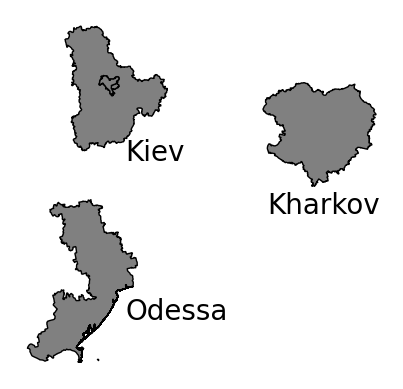

In [ ]:
shape = gpd.read_file('UKR.shp')
shape = shape[(shape['NAME_1']=='Kiev') | (shape['NAME_1']=='Kiev City') | (shape['NAME_1']=='?') | (shape['NAME_1']=='Kharkiv')|\
              (shape['NAME_1']=='Odessa')]
shape.plot(color='grey', edgecolor='black')

plt.axis('off')
plt.text(35,48, 'Kharkov', fontsize=20)
plt.text(31,46, 'Odessa', fontsize=20)
plt.text(31,49, 'Kiev', fontsize=20)
plt.savefig('UKR_shape.png')
plt.show()

In [ ]:
def to_array(data_list, i, roi):
    img = ee.Image(data_list.get(i))
    img = img.addBands(img.pixelLonLat()).reproject('EPSG:4326', scale=500, crsTransform=None)
    array = ee.data.computePixels({
      'expression': img.clip(roi),
      'fileFormat': 'NUMPY_NDARRAY'
    })
    timestamp = img.get('system:time_start').getInfo()

    date = datetime.datetime.utcfromtimestamp(timestamp / 1000)
    return array, date

In [ ]:
def plot(city, arrays, dates, rads):
  def update(frame):
    im1.set_data(arrays[frame])

    info_text = (
        f"Date: {pd.to_datetime(dates[frame]).strftime(format='%Y-%m-%d')}\n"
    )
    text.set_text(info_text)
    ax[0].axis('off')

    im2.set_data(dates[0:frame+1], rads[0:frame+1])

    ax[1].relim()
    return [im1, im2]

  colors = [(0, 0, 0), (1, 1, 0)]
  cmap_name = 'black_yellow'
  black_yellow_cmap = LinearSegmentedColormap.from_list(cmap_name, colors)

  llim = -1 if city[0]=='Kiev' else -0.5
  if city[0]=='Kiev':
    y_text = 520
  elif city[0]=='Odessa':
     y_text = 680
  else:
     y_text = 440

  fig, ax = plt.subplots(1,2,figsize=(12,8), frameon=False)
  im1 = ax[0].imshow(arrays[0], vmax=10, cmap=black_yellow_cmap)
  text = ax[0].text(20, y_text, "", ha='left', fontsize=14, fontname='monospace', color='white')

  im2, = ax[1].plot(dates[0], rads[0], marker='o',color='black', lw=2)
  plt.xticks(rotation=45)
  ax[1].axvline(pd.to_datetime('2022-02-01'), lw=3, color='red')
  ax[1].axhline(0, lw=3, color='black')
  ax[1].axhline(0, lw=1.5, ls='--', color='yellow')
  ax[1].grid(False)
  ax[1].spines[['right', 'top']].set_visible(False)
  ax[1].set_xlabel('Date', fontsize=14, fontname='monospace')
  ax[1].set_ylabel('Average DNB radiance', fontsize=14, fontname='monospace')
  ax[1].set_ylim(llim, max(rads)+0.1)
  ax[1].set_xlim(min(dates), max(dates))
  plt.suptitle(city[0], fontsize=20)



  ani = animation.FuncAnimation(fig, update, frames=27, interval=40)
  ani.save(f'{city[0]}.gif', fps=0.5, savefig_kwargs={'pad_inches':0, 'bbox_inches': 'tight'})
  plt.show()

In [ ]:
def generate_csv(city):
  shape = gpd.read_file('UKR.shp')
  shape = shape[shape['NAME_1'].isin(city)]

  js = json.loads(shape.to_json())
  roi = ee.Geometry(ee.FeatureCollection(js).geometry())

  startDate = pd.to_datetime('2012-01-01')#2014
  endDate = pd.to_datetime('2024-04-01')
  data = ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG")\
                  .filterBounds(roi)\
                  .filterDate(start = startDate, end=endDate)

  arrays, dates, rads = [], [], []
  if data.size().getInfo()!=0:
      data_list = data.toList(data.size())
      for i in range(data_list.size().getInfo()):
          array, date = to_array(data_list,i, roi)


          rads.append(array['avg_rad'][np.where(array['cf_cvg']>1)].mean())
          dates.append(date)
          if date>=pd.to_datetime('2022-01-01'):
            arrays.append(array['avg_rad'])
          print(f'Index: {i+1}/{data_list.size().getInfo()+1}')
  df = pd.DataFrame({'date': dates, 'avg_rad':rads})
  np.save(f'{city[0]}.npy', arrays, allow_pickle=True)
  df.to_csv(f'{city[0]}.csv', index=None)

In [ ]:
def gif(city):
  array = np.load(f'{city[0]}.npy')
  df = pd.read_csv(f'{city[0]}.csv')
  df.date = pd.to_datetime(df.date)
  ts_lon = df[df.date<pd.to_datetime('2022-01-01')].set_index('date')
  means = ts_lon.groupby(ts_lon.index.month).mean()

  ts_short = df[df.date>=pd.to_datetime('2022-01-01')].set_index('date')
  ts_short['month'] = ts_short.index.month
  anomaly = ts_short['avg_rad']-ts_short['month'].map(means['avg_rad'])

  plot(city, array, ts_short.index.values, anomaly.values)

In [ ]:
city = ['Kiev', 'Kiev City', '?']
city = ['Kharkiv']
city = ['Odessa']

generate_csv(city)

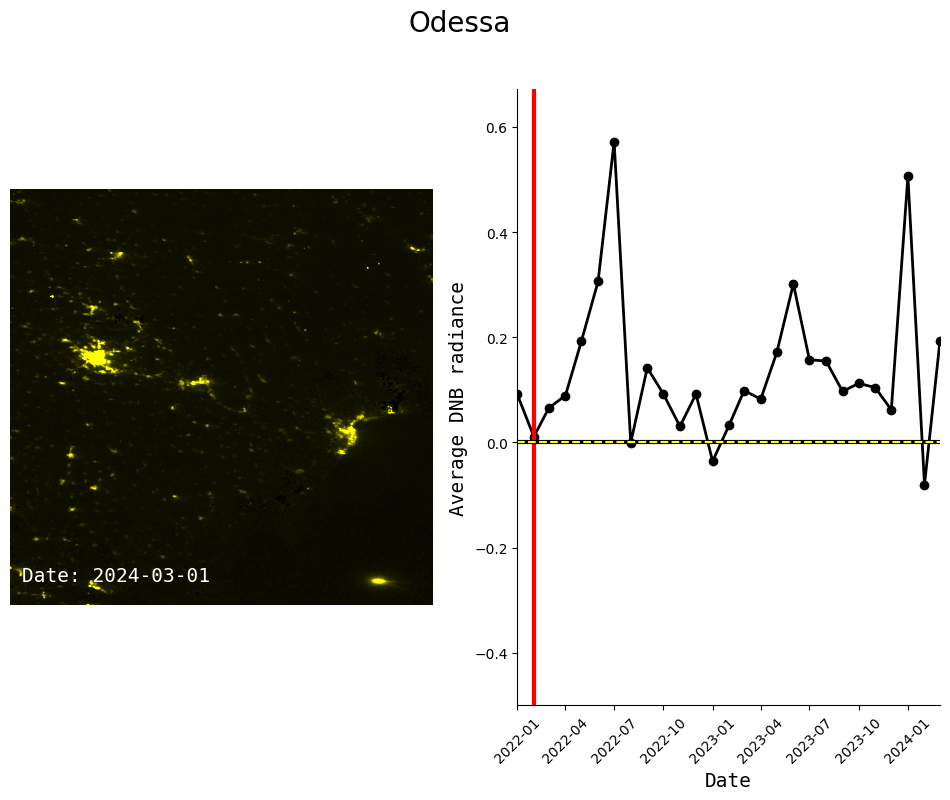

In [ ]:
city = ['Kiev', 'Kiev City', '?']
city = ['Kharkiv']
city = ['Odessa']

gif(city)

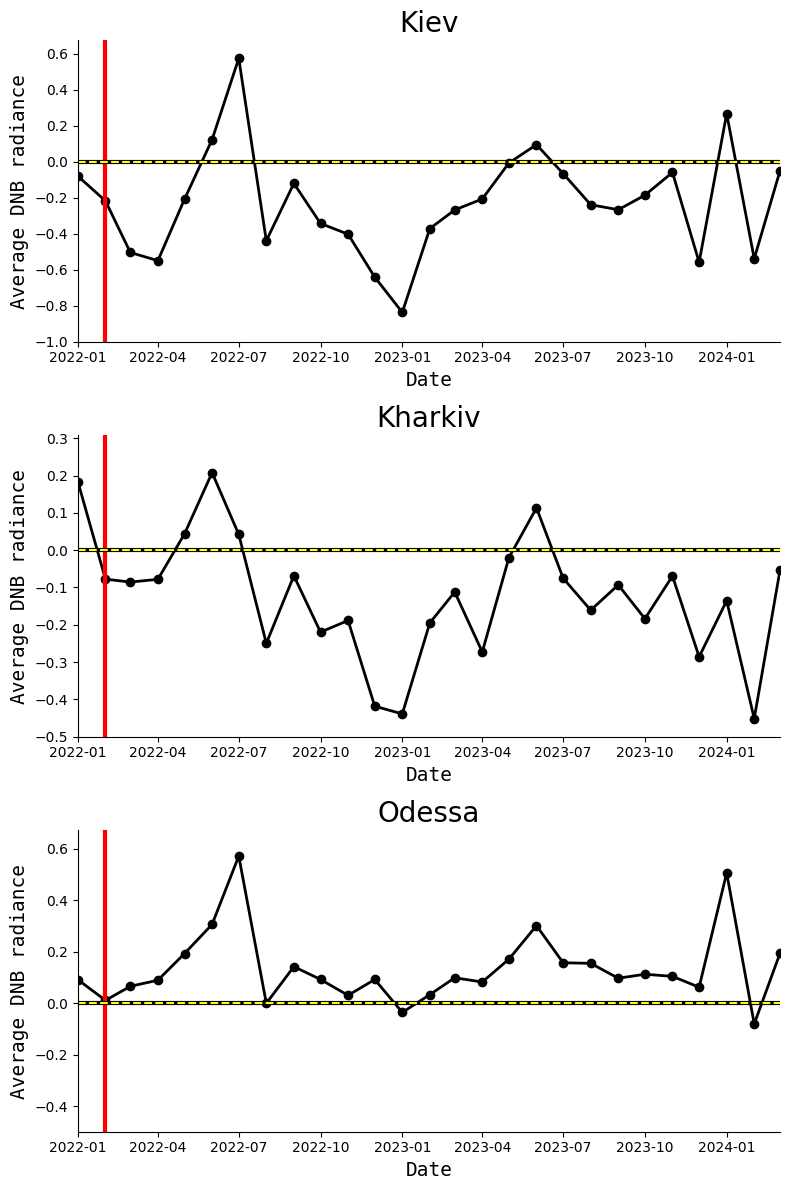

In [ ]:
fig, ax = plt.subplots(3,1,figsize=(8,12), frameon=False)
cities = [['Kiev', 'Kiev City', '?'], ['Kharkiv'], ['Odessa']]
for i, city in enumerate(cities):
  array = np.load(f'{city[0]}.npy')
  df = pd.read_csv(f'{city[0]}.csv')
  df.date = pd.to_datetime(df.date)
  ts_lon = df[df.date<pd.to_datetime('2022-01-01')].set_index('date')
  means = ts_lon.groupby(ts_lon.index.month).mean()

  ts_short = df[df.date>=pd.to_datetime('2022-01-01')].set_index('date')
  ts_short['month'] = ts_short.index.month
  anomaly = ts_short['avg_rad']-ts_short['month'].map(means['avg_rad'])

  llim = -1 if city[0]=='Kiev' else -0.5

  im2, = ax[i].plot(ts_short.index.values, anomaly.values, marker='o',color='black', lw=2)

  ax[i].axvline(pd.to_datetime('2022-02-01'), lw=3, color='red')
  ax[i].axhline(0, lw=3, color='black')
  ax[i].axhline(0, lw=1.5, ls='--', color='yellow')
  ax[i].grid(False)
  ax[i].spines[['right', 'top']].set_visible(False)
  ax[i].set_xlabel('Date', fontsize=14, fontname='monospace')
  ax[i].set_ylabel('Average DNB radiance', fontsize=14, fontname='monospace')
  ax[i].set_ylim(llim, max(anomaly.values)+0.1)
  ax[i].set_xlim(min(ts_short.index.values), max(ts_short.index.values))
  ax[i].set_title(city[0],fontsize=20)
plt.tight_layout()
plt.savefig('Lineplot.png')